# Classification Project

Date: 13/03/20 <br>

## Abstract

This project aims to find out a classification method to identify which area's of interest our users have in relation to the query used by the time they Googled and hit one of our site corresponding pages.

Having not an official list of keywords vs. area of the site, using the January '20 and February '20 Google Search Console data, I have manually classyfied roughly 1000 keywords in order to have a source of truth.

With the trained data set, a several supervised learning based on Naive Bayes have been used to determine the accuracy between of the prediction.

## Source the data

Import the dataset generated specifically for this exercise, and clean it where opportune.

In [28]:
import pandas as pd
file = './cleaned_data.xlsx'

df = pd.read_excel(file, sheet_name='Classification')
df.head(3)

,Term,TAG
0,rs components,Branded
1,rs,Branded
2,rs components uk,Branded


During the execution of this project I realised that certain elements of my dataset where creating a noise. I, therefore, have decided to remove them so to maintain an optimal level of accuracy.<br>
This part has been intentionally omitted from the final output of this project to maintain the project as readable as possible. 

In [29]:
# Get names of indexes for which column TAG contains a Branded value
indexNames = df[(df['TAG'] == 'Branded') | (df['TAG'] == 'Brands') | (df['TAG'] == 'Product') | (df['TAG'] == 'Other')].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames, inplace=True)

Let's check the tags that were identified

In [30]:
df.TAG.value_counts().sort_index()

Abrasives & Engineering Materials           8
Automation & Control Gear                  45
Automation & Control gear                   7
Batteries & Chargers                        8
Cables & Wires                             82
Capacitors                                  1
Cleaning & Maintenance                      2
Computing & Peripherals                     5
Connectors                                 43
Displays & Optoelectronics                 15
Enclosures, Storage & Material Handling    16
Facilities & cleaning                       1
Fans & Thermal Management                   8
Fasteners & Fixings                        42
Fuses & Sockets                            15
Lighting                                    3
Office Supplies                             2
Office supplies                             1
PCB Prototyping                             7
Passive Components                         20
Plumbing & Pipeline                         8
Pneumatics & Hydraulics           

There are some elements that are the same, just with different capitalisation. Let's fix this!

In [31]:
df.TAG[(df.TAG == 'Automation & Control gear')] = 'Automation & Control Gear'
df.TAG[(df.TAG == 'Office supplies')] = 'Office Supplies'
df.TAG[(df.TAG == 'Sealants & tapes')] = 'Sealants & Tapes'

Let's plot again the values to understand how balanced is my dataset.

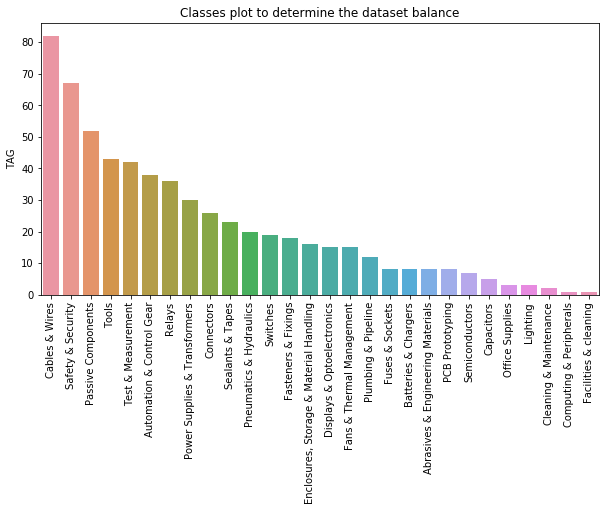

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.tick_params(axis='x', labelrotation=90)
plt.title('Classes plot to determine the dataset balance')
sns.barplot(y=df.TAG.value_counts(), x=df.TAG.unique(), data=df, ax=ax1)

The dataset is highly imbalanced.

With such a scenario, I'm likelty to have difficulties classyfying the dataset as the minority classes are likely to be treated as outliers and ignored.<br>
Situations like this could be managed carefully configuring the model or artificially balance the dataset, for example by [undersampling or oversampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) each class.

At this stage there is very little I can do, as the imbalance is in any case real and given by the type of products RS sell and how the company is positioned on the market.

I progress anyway with what I have at hands.

## Data Cleaning

In this step, feature engineering, I focus on cleaning the text.

In [33]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import string

# This is the a word tokenizer later user with the TfidfVectorizer
def word_tokenizer(text, stem=True):
    #tokenizes and stems the text
    tokens = word_tokenize(text.lower())
    punctuation = string.punctuation + '’'
    tokens = list(filter(lambda token: token not in punctuation, tokens))

    if stem==True:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
    else:
        tokens = [t for t in tokens if t not in stopwords.words('english')]

    return tokens

In [34]:
corpus = df.Term.to_list()

In [35]:
from gensim import corpora

# Remove common words and tokenize
# do it using the routine created before
texts = [
    word_tokenizer(document, False)
    for document in corpus
]

dictionary = corpora.Dictionary(texts)

Below I focus on extracting features out of the text because I need numerical features as input for the classifier. An intuitive choice is the word frequencies (e.g. counting the occurrence of every word in the document).

I then ran a second algorithm (TF-IDF) to transform the text into data that can be easily analyzed and quantify, which basically reflects how important a word is to a document in a corpus (my set of searched terms).

In [36]:
from gensim.models.tfidfmodel import TfidfModel

# The gensim TF-IDF model requires a data structure in a Bag of Word format (which is still a vector).
new_corpus = [dictionary.doc2bow(text) for text in texts]
tfidf_model = TfidfModel(new_corpus, smartirs='Lpc')
corpus_tfidf = tfidf_model[new_corpus]

____
NOTE: I have attempted the use of different combination of the `smartirs` parameter without recording any difference in the accuracy.
____

In [37]:
from gensim.matutils import corpus2csc

X = corpus2csc(corpus_tfidf).transpose()
y = df.TAG

## Data Prediction & Evaluation

At this stage, I have to implement a Naive Bayes algoritm to predict the values at which each of my rows would be associated. I will go with the `Gaussian` method.

**Why the Gaussian?**

I am working with text, and each of the word has been previously transformed into a dictionary of items for which I have found the number of occurrences. In such a situation, the `Multinomial naive Bayes` would have been more appropriate since this is used with discrete data (e.g. movie ratings ranging 1 and 5 as each rating will have certain frequency to represent).

However, since I have also decided to ran past my corpus with the TF-IDF, the returned data representing the frequency/importance of each of the term found in the dictionary are continuous and infinite (and in theory normally distributed). For such a reason the `Gaussian` method is more indicated.

In [38]:
print('This is the terms/frequency by the time the Bag of Words was run.')
print(new_corpus[0:5])
print()
print('This is the continuous data once transformed via the TD-IDF.')
print(X[0:5])

This is the terms/frequency by the time the Bag of Words was run.
[[(0, 1), (1, 1)], [(2, 1), (3, 1), (4, 1)], [(4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1)], [(9, 1), (10, 1)]]

This is the continuous data once transformed via the TD-IDF.
  (0, 0)	0.5129392291423214
  (0, 1)	0.8584249222890032
  (1, 2)	0.7105712794557967
  (1, 3)	0.5731220578035463
  (1, 4)	0.4081905972356304
  (2, 4)	0.40436133512239814
  (2, 5)	0.4617142758939492
  (2, 6)	0.7895010057585474
  (3, 7)	0.6278060158500727
  (3, 8)	0.7783698391269143
  (4, 9)	0.7363811268603015
  (4, 10)	0.6765669486488033


In [39]:
from sklearn.model_selection import train_test_split

# Implementing the Gaussian algorithm
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

X_train, X_test, Y_train, Y_test = train_test_split(X.toarray(), y, test_size=0.20, random_state=456)
gnb.fit(X_train, Y_train)
y_pred = gnb.predict(X_test)

In [40]:
from sklearn import metrics
print(f'Recall Score: {metrics.recall_score(Y_test, y_pred, average="weighted")*100:.2f}%')
print(f'Precision Score: {metrics.precision_score(Y_test, y_pred, average="weighted", zero_division=1)*100:.2f}%')

Recall Score: 65.57%
Precision Score: 78.08%


Using just 20% of my data I obtain a 65% recall score.<br>
____
**NOTE**: Since I am working with a Multiclass dataset, both the Accuracy and the Recall would be the same, but for the sake of correctness I have to pick the most appropriate metric - Recall.
____

Would this change using the whole dataset?

In [41]:
# Predict the values of the whole set
gnb.fit(X.toarray(), y)
y_pred = gnb.predict(X.toarray())

# Verify the accuracy and Recall
print(f'Recall Score: {metrics.recall_score(y, y_pred, average="weighted")*100:.2f}%')
print(f'Precision Score: {metrics.precision_score(y, y_pred, average="weighted", zero_division=1)*100:.2f}%')

Recall Score: 97.53%
Precision Score: 97.76%


A 97% accuracy score! An amazing result!
The score would have been much lower, around 55% if I would have left the TAGs previously removed.

**NOTE** Both the Accuracy and Recall show the same value, and this sounds a bit strange.

Let's try to run past the data set via the Multinomial algorithm and check what the accuracy score is.

In [42]:
from sklearn.naive_bayes import MultinomialNB

In [43]:
mnb = MultinomialNB()
mnb.fit(X.toarray(), y)
MultinomialNB()

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [44]:
# Predict the values of the whole set
y_pred = mnb.predict(X.toarray())

In [45]:
# Verify the accuracy and Recall
print(f'Recall Score: {metrics.recall_score(y, y_pred, average="weighted")*100:.2f}%')
print(f'Precision Score: {metrics.precision_score(y, y_pred, average="weighted", zero_division=1)*100:.2f}%')

Recall Score: 74.34%
Precision Score: 85.38%


As it can be seen, the obtained Accuracy score is ultimately lower than before. 

I don't think that splitting results in a training/testing subset can help, but worth a try.

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X.toarray(), y, test_size=0.25, random_state=456)
mnb.fit(X_train, Y_train)
y_pred = mnb.predict(X_test)

In [47]:
print(f'Recall Score: {metrics.recall_score(Y_test, y_pred, average="weighted")*100:.2f}%')
print(f'Precision Score: {metrics.precision_score(Y_test, y_pred, average="weighted", zero_division=1)*100:.2f}%')

Recall Score: 46.71%
Precision Score: 77.82%


The % decreased massively, thus confirming this is not the best approach.

However, although the Recall is mostly ok for a multiclass evaluation, Precision is not. That said, the method above do an average across all the classes, which is not a problem now with the 97% recall score, but it would have been with a lower results. 

This makes the above assessment NOT entirely correct for a multi-class evaluation, and something more appropriate has to be used.

## Data evaluation - Using the right metrics

Let's reset to the Gaussian method and visually represent the results preparing and plotting a multinomial confusion matrix.

In [48]:
# Reset the values to include the whole data set. Assign to the value to the train split test variable so I can easily comment these line out if necessary.
gnb.fit(X.toarray(), y)
y_pred = gnb.predict(X.toarray())
Y_test = y

Print a classification report to see at a glance what the situation looks like

In [49]:
from sklearn.metrics import classification_report
import numpy

print(classification_report(Y_test, y_pred, target_names=numpy.unique(Y_test), zero_division=1))

                                         precision    recall  f1-score   support

      Abrasives & Engineering Materials       1.00      1.00      1.00         8
              Automation & Control Gear       1.00      0.96      0.98        52
                   Batteries & Chargers       1.00      1.00      1.00         8
                         Cables & Wires       1.00      1.00      1.00        82
                             Capacitors       1.00      1.00      1.00         1
                 Cleaning & Maintenance       1.00      1.00      1.00         2
                Computing & Peripherals       1.00      1.00      1.00         5
                             Connectors       0.98      0.98      0.98        43
             Displays & Optoelectronics       0.83      1.00      0.91        15
Enclosures, Storage & Material Handling       1.00      1.00      1.00        16
                  Facilities & cleaning       1.00      1.00      1.00         1
              Fans & Therma

By returning metrics for each class it would be easier to determine where problems lie.

As a reminder:

**Precision**: precision is used to measure the positive patterns that are correctly predicted from the total predicted patterns in a positive class.<br>
**Recall**: Out of all the positive classes, how many instances were identified correctly.<br>
**F1-Score**: this metric represents the harmonic mean between recall and precision values

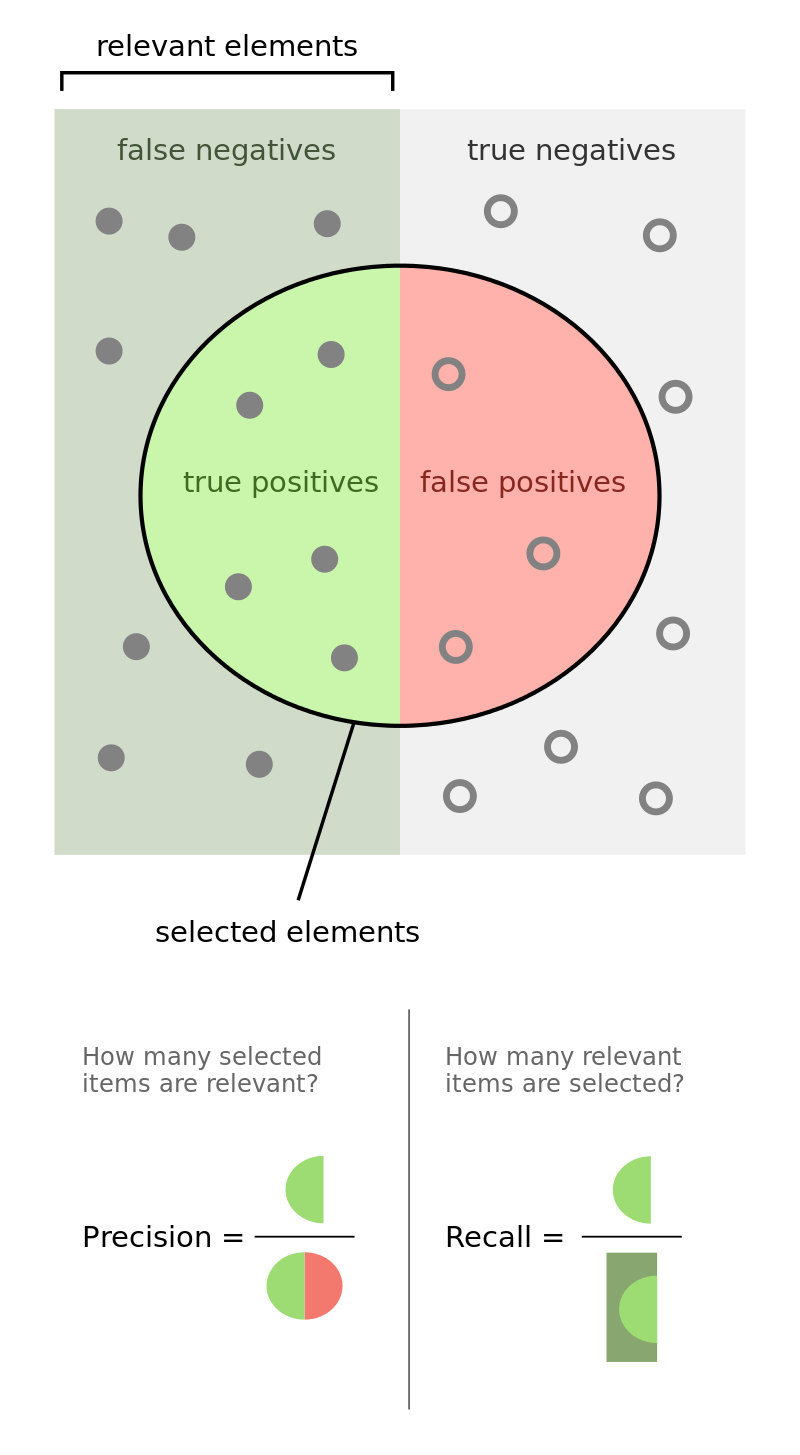

Other commonly used metrics for multi-classes evaluation are the Average Accuracy or the Log-loss. There is yet no well-developed ROC-AUC score for multi-class.

The Log-loss is a de-facto metric for multiclass classification, even in ML competitions as __it compare the model not only on the output but on the probabilistic outcome__.<br>
To work, the log_loss function computes results by looking at a list of ground-truth labels and the probability matrix returned by the estimator.

In [50]:
from sklearn.metrics import log_loss
print(f'The log loss is {log_loss(y, gnb.predict_proba(X.toarray()))*100:.2f}%')

The log loss is 80.77%


That said, log loss is deemed suitable with a balanced dataset and misleading when there is a large imbalance (Normally between the classes in the test set).
In my case, although I have used no test set, I still have a large imbalanced class, hence I'm not fully sure the final result is positive.

### The confusion matrix

Not really necessary at this stage, since I have almost accrued a good level of confidence about this model. However, this is first time I use a multi-class hence I'm keen to visualise results in confusion matrix too.

In [51]:
# To do this, I can use either the Sklearn library or the mlxtend
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(Y_test, y_pred, labels=numpy.unique(Y_test))

## OR  
# from mlxtend.evaluate import confusion_matrix
# cm = confusion_matrix(y_target=Y_test, 
#                       y_predicted=y_pred, 
#                       binary=False, positive_label=numpy.unique(Y_test))

Plot the confusion matrix via the mlxtend library, the only one I was able to see working properly for a multi-class.
from mlxtend.plotting import plot_confusion_matrix

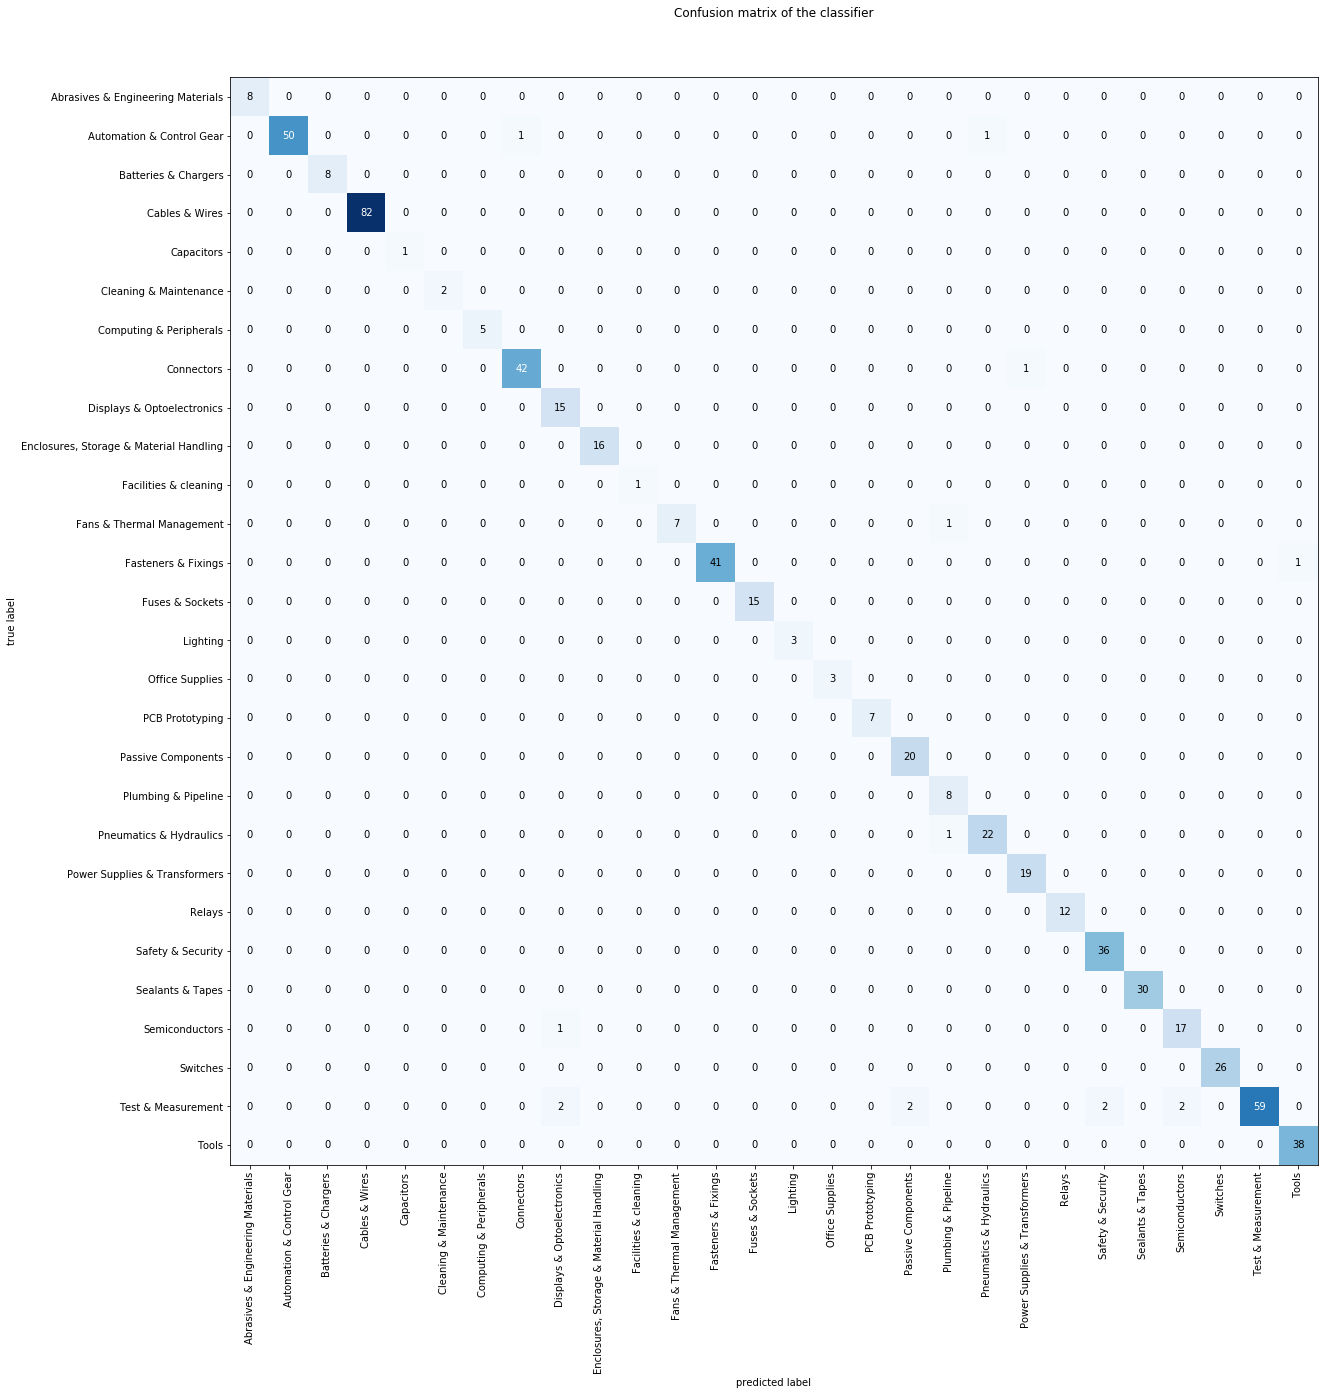

In [52]:
# Plot the confusion matrix 
from mlxtend.plotting import plot_confusion_matrix 
fig, ax = plot_confusion_matrix(conf_mat=cm,figsize=(20,20), class_names=numpy.unique(Y_test))
ax.tick_params(axis='x', labelrotation=90)
plt.title('Confusion matrix of the classifier')
plt.show()

The above confusion matrix tells a story, but the diagonal line (the interception between each items) colour coding doesn't seems to be fully explanatory.<br>
In fact, even with a full match, the colour between each class is not in agreement with each class, thus suggesting the above plotting not particularly useful, not at least visually.

For the sake of practicing, I print out values in a different way using the multilabel_confusion_matrix.

In [53]:
# Printing a multilabel confusion matrix with the Sklearn library proves no usefulness 
cm_results = metrics.multilabel_confusion_matrix(Y_test, y_pred, labels=numpy.unique(y_pred))

# Applying a tolist method just for the sake of compressing the output
cm_results.tolist()

[[[600, 0], [0, 8]],
 [[556, 0], [2, 50]],
 [[600, 0], [0, 8]],
 [[526, 0], [0, 82]],
 [[607, 0], [0, 1]],
 [[606, 0], [0, 2]],
 [[603, 0], [0, 5]],
 [[564, 1], [1, 42]],
 [[590, 3], [0, 15]],
 [[592, 0], [0, 16]],
 [[607, 0], [0, 1]],
 [[600, 0], [1, 7]],
 [[566, 0], [1, 41]],
 [[593, 0], [0, 15]],
 [[605, 0], [0, 3]],
 [[605, 0], [0, 3]],
 [[601, 0], [0, 7]],
 [[586, 2], [0, 20]],
 [[598, 2], [0, 8]],
 [[584, 1], [1, 22]],
 [[588, 1], [0, 19]],
 [[596, 0], [0, 12]],
 [[570, 2], [0, 36]],
 [[578, 0], [0, 30]],
 [[588, 2], [1, 17]],
 [[582, 0], [0, 26]],
 [[541, 0], [8, 59]],
 [[569, 1], [0, 38]]]

The function above prints the TP, TN, FP and FN for each classes, but results are not easy to read. 

I will pack them into a dataframe for a better visualization.

In [54]:
expanded_confusion_matrix = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN'])

for index, i in enumerate(cm_results):
    TP = cm_results[index][1][1]
    TN = cm_results[index][0][0]
    FP = cm_results[index][0][1]
    FN = cm_results[index][1][0]
    
    expanded_confusion_matrix = expanded_confusion_matrix.append({'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}, ignore_index=True)

expanded_confusion_matrix['Label'] = numpy.unique(y_pred)
expanded_confusion_matrix.set_index("Label", inplace=True)

expanded_confusion_matrix

,TP,TN,FP,FN
Label,,,,
Abrasives & Engineering Materials,8,600,0,0
Automation & Control Gear,50,556,0,2
Batteries & Chargers,8,600,0,0
Cables & Wires,82,526,0,0
Capacitors,1,607,0,0
Cleaning & Maintenance,2,606,0,0
Computing & Peripherals,5,603,0,0
Connectors,42,564,1,1
Displays & Optoelectronics,15,590,3,0


I will then manually calculate the different metrics. Again this is done for practising purpose.

True Poisitive Rate OR Sensitivity OR Recall = True Positives / (True Positives + False Negatives)<br>
TPR = 50 / (50 + 2) = 0.96 (Automation & Control Gear)

False Positive Rate = False Positives / (False Positives + True Negatives)<br>
FPR = 0 / (0 + 556) = 0

Specificity = True Negatives / (True Negatives + False Positives)<br>
Specificity = 556 / (556 + 2) = 1

In [55]:
expanded_confusion_matrix = expanded_confusion_matrix.astype('int32')

In [56]:
expanded_confusion_matrix['TPR'] = expanded_confusion_matrix.apply(lambda x: (x.TP / (x.TP + x.FN)), axis=1)
expanded_confusion_matrix['FPR'] = expanded_confusion_matrix.apply(lambda x: (x.FP / (x.FP + x.TN)), axis=1)
expanded_confusion_matrix['Specificity'] = expanded_confusion_matrix.apply(lambda x: (x.TN / (x.TN + x.FP)), axis=1)

In [57]:
# Print again the table rounding the new values
expanded_confusion_matrix.round(2)

,TP,TN,FP,FN,TPR,FPR,Specificity
Label,,,,,,,
Abrasives & Engineering Materials,8,600,0,0,1.00,0.00,1.00
Automation & Control Gear,50,556,0,2,0.96,0.00,1.00
Batteries & Chargers,8,600,0,0,1.00,0.00,1.00
Cables & Wires,82,526,0,0,1.00,0.00,1.00
Capacitors,1,607,0,0,1.00,0.00,1.00
Cleaning & Maintenance,2,606,0,0,1.00,0.00,1.00
Computing & Peripherals,5,603,0,0,1.00,0.00,1.00
Connectors,42,564,1,1,0.98,0.00,1.00
Displays & Optoelectronics,15,590,3,0,1.00,0.01,0.99


Finally, let's understand out of my classification test, how many items have not fit.

In [58]:
df_preds = pd.DataFrame(data=zip(pd.DataFrame(y_pred)[0].value_counts(), Y_test.value_counts()),
                        index=Y_test.value_counts().index,
                        columns=['y_pred', 'y_test'])
df_preds['diff'] = df_preds.apply(lambda x: x['y_test'] - x['y_pred'], axis=1)

In [59]:
df_preds[(df_preds['diff'] > 0) | (df_preds['diff'] < 0)]

,y_pred,y_test,diff
Test & Measurement,59,67,8
Automation & Control Gear,50,52,2
Fasteners & Fixings,41,42,1
Tools,39,38,-1
Safety & Security,38,36,-2
Passive Components,22,20,-2
Power Supplies & Transformers,20,19,-1
Semiconductors,19,18,-1
"Enclosures, Storage & Material Handling",18,16,-2
Displays & Optoelectronics,16,15,-1


## Conclusions

- The decision to manually classify items for this exercise has not helped due to the biased data, which ended up in a 28 multi-class dataset (Far too much for a learning project)
- Despite the imbalanced class, this Naive Bayes classification returned a 97% recall score and an 80% Log Loss score. It is my understanding that given the scenario, the Log Loss value is good, but further confirmation is required.
    - Ideally the mentor or some other data scientist should confirm
- It would be interesting counterverify the model with a new set of keywords. However, March keywords are not yet available.

During the course of this project I couldn't find any decent method to display properly the results of the confusion matrix. A DataFrame approach was used, which was later used to calculate other metrics, though at this stage it is not clear whether these are useful.

### References
- https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
- https://medium.com/@fzammito/whats-considered-a-good-log-loss-in-machine-learning-a529d400632d
- https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
- https://www.youtube.com/watch?v=bTs-QA2oJSE